In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import matplotlib.pyplot as plt 
from collections import deque 

from vehicle_model_DDQN3_3 import Environment 
from cell_model import CellModel 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
drving_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_e-4wd_Battery.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_id_75_110_Westinghouse.mat"
cell_model = CellModel()
env = Environment(cell_model, drving_cycle, battery_path, motor_path, 1)


In [3]:
# STATE_SIZE = env.calculation_comp["state_size"]
STATE_SIZE = 4
ACTION_SIZE = env.calculation_comp["action_size"] 
LEARNING_RATE = 0.00025 

TOTAL_EPISODES = 200
MAX_STEPS = 50000 

GAMMA = 0.95 

MAX_EPSILON = 1 
MIN_EPSILON = 0.01 
DECAY_RATE = 0.00002
BATCH_SIZE = 32 
TAU = 0.001 
DELAY_TRAINING = 3000 
EPSILON_MIN_ITER = 5000

In [4]:
primary_network = keras.Sequential([
    keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()), 
#     keras.layers.BatchNormalization(), 
    keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()),
#     keras.layers.BatchNormalization(), 
    keras.layers.Dense(ACTION_SIZE),
])
target_network = keras.Sequential([
    keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()), 
#     keras.layers.BatchNormalization(), 
    keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()),
#     keras.layers.BatchNormalization(), 
    keras.layers.Dense(ACTION_SIZE),
])

primary_network.compile(
    loss="mse", 
    optimizer=keras.optimizers.Adam(lr=LEARNING_RATE) 
)

# for t, p in zip(target_network.trainable_variables, primary_network.trainable_variables): 
#     t.assign(p)

In [5]:
def update_network(primary_network, target_network): 
    for t, p in zip(target_network.trainable_variables, primary_network.trainable_variables): 
        t.assign(t * (1 - TAU) + p * TAU)

In [6]:
class Memory: 
    def __init__(self, max_memory): 
        self.max_memory = max_memory 
        self._samples = [] 
        
        self.power_mean = 0 
        self.power_std = 0 
        self.sum = 0 
        self.sum_deviation = 0 
        self.N = 0 
        
    def add_sample(self, sample): 
        self.N += 1 
        power = sample[0][0]
        self.sum += power 
        self.power_mean = self.sum / self.N 
        self.sum_deviation += (power - self.power_mean) ** 2
        self.power_std = np.sqrt(self.sum_deviation / self.N)
        
        self._samples.append(sample)
        if len(self._samples) > self.max_memory: 
            self._samples.pop(0)
        
    def sample(self, no_samples): 
        if no_samples > len(self._samples): 
            return random.sample(self._samples, len(self._samples))
        else: 
            return random.sample(self._samples, no_samples)
    
    @property
    def num_samples(self):
        return len(self._samples)
    

# memory = Memory(10000)

In [7]:
def choose_action(state, primary_network, eps): 
    if random.random() < eps: 
        return random.randint(0, ACTION_SIZE - 1)
    else: 
        return np.argmax(primary_network(np.array(state).reshape(1, -1))) 

In [8]:
def train(primary_network, target_network, memory): 
    batch = memory.sample(BATCH_SIZE)
    states = np.array([val[0] for val in batch]) 
    actions = np.array([val[1] for val in batch])
    rewards = np.array([val[2] for val in batch])
    next_states = np.array([np.zeros(STATE_SIZE) if val[3] is None else val[3]  
                            for val in batch])
    next_power_states = np.array([0 if val[3] is None else (val[3][0] - memory.power_mean) / memory.power_std  
                        for val in batch])
    
    states[:, 0] = (states[:, 0] - memory.power_mean) / memory.power_std 
    next_states[:, 0] = next_power_states
    
    prim_qt = primary_network(states)
    prim_qtp1 = primary_network(next_states)
    target_q = prim_qt.numpy() 
    updates = rewards 
    valid_idxs = next_states.sum(axis=1) != 0 
    batch_idxs = np.arange(BATCH_SIZE)
    prim_action_tp1 = np.argmax(prim_qtp1.numpy(), axis=1)
    q_from_target = target_network(next_states)
    updates[valid_idxs] += GAMMA * q_from_target.numpy()[batch_idxs[valid_idxs], 
                                                        prim_action_tp1[valid_idxs]]
    
    target_q[batch_idxs, actions] = updates 
    loss = primary_network.train_on_batch(states, target_q)
    return loss 
    
    
    

In [9]:
def initialization_with_rewardFactor(reward_factor):
    env = Environment(cell_model, drving_cycle, battery_path, motor_path, reward_factor)
    
    memory = Memory(10000)
    
    primary_network = keras.Sequential([
        keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()),
#         keras.layers.BatchNormalization(),  
        keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()),
#         keras.layers.BatchNormalization(), 
        keras.layers.Dense(ACTION_SIZE),
    ])
    target_network = keras.Sequential([
        keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()), 
#         keras.layers.BatchNormalization(), 
        keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()),
#         keras.layers.BatchNormalization(), 
        keras.layers.Dense(ACTION_SIZE),
    ])
    primary_network.compile(
        loss="mse", 
        optimizer=keras.optimizers.Adam(lr=LEARNING_RATE) 
    )
    return env, memory, primary_network, target_network 
    

In [10]:
print("environment version: {}".format(env.version)) 

reward_factors = [10]
results_dict = {} 

for reward_factor in reward_factors: 
    eps = MAX_EPSILON 
    steps = 0
    episode_rewards = [] 
    episode_SOCs = [] 
    episode_FCs = [] 
    
    env, memory, primary_network, target_network = initialization_with_rewardFactor(reward_factor)
    for episode in range(TOTAL_EPISODES): 
        state = env.reset() 
        avg_loss = 0 
        total_reward = 0
        cnt = 1 

        while True:
            action = choose_action(state, primary_network, eps)
            next_state, reward, done = env.step(action)
            total_reward += reward 
            if done: 
                next_state = None 
            memory.add_sample((state, action, reward, next_state))

            if steps > DELAY_TRAINING: 
                loss = train(primary_network, target_network, memory)
                update_network(primary_network, target_network)
                eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * steps)
            else: 
                loss = -1

            avg_loss += loss 
            steps += 1 

            if done: 
                if steps > DELAY_TRAINING: 
                    SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
                    avg_loss /= cnt 
                    print('Episode: {}'.format(episode + 1),
                          'Total reward: {}'.format(total_reward), 
                          'Explore P: {:.4f}'.format(eps), 
                          "SOC: {:.4f}".format(env.SOC), 
                         "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
                         "Fuel Consumption: {:.4f}".format(env.fuel_consumption), 
                         )
                else: 
                    print(f"Pre-training...Episode: {episode}")
                
                episode_rewards.append(total_reward)
                episode_SOCs.append(env.SOC)
                episode_FCs.append(env.fuel_consumption)
                break 

            state = next_state 
            cnt += 1 
    
    results_dict[reward_factor] = {
        "rewards": episode_rewards, 
        "SOCs": episode_SOCs, 
        "FCs": episode_FCs 
    }
            
    

environment version: 3
maximum steps, simulation is done ... 
Pre-training...Episode: 0
maximum steps, simulation is done ... 
Pre-training...Episode: 1

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer

maximum steps, simulation is done ... 
Episode: 41 Total reward: -548.3934269998673 Explore P: 0.3311 SOC: 0.6838 Cumulative_SOC_deviation: 49.7121 Fuel Consumption: 51.2726
maximum steps, simulation is done ... 
Episode: 42 Total reward: -566.1602329946952 Explore P: 0.3224 SOC: 0.6291 Cumulative_SOC_deviation: 51.8740 Fuel Consumption: 47.4200
maximum steps, simulation is done ... 
Episode: 43 Total reward: -582.0207519526581 Explore P: 0.3140 SOC: 0.6999 Cumulative_SOC_deviation: 52.9404 Fuel Consumption: 52.6166
maximum steps, simulation is done ... 
Episode: 44 Total reward: -616.9645215743582 Explore P: 0.3057 SOC: 0.7232 Cumulative_SOC_deviation: 56.2922 Fuel Consumption: 54.0427
maximum steps, simulation is done ... 
Episode: 45 Total reward: -462.59967232696033 Explore P: 0.2977 SOC: 0.6727 Cumulative_SOC_deviation: 41.2735 Fuel Consumption: 49.8648
maximum steps, simulation is done ... 
Episode: 46 Total reward: -620.3617068490959 Explore P: 0.2899 SOC: 0.7029 Cumulative_SOC_

maximum steps, simulation is done ... 
Episode: 89 Total reward: -819.9338616543862 Explore P: 0.0960 SOC: 0.7777 Cumulative_SOC_deviation: 76.1554 Fuel Consumption: 58.3802
maximum steps, simulation is done ... 
Episode: 90 Total reward: -786.0728440673234 Explore P: 0.0936 SOC: 0.7429 Cumulative_SOC_deviation: 73.0789 Fuel Consumption: 55.2843
maximum steps, simulation is done ... 
Episode: 91 Total reward: -697.5365460971398 Explore P: 0.0914 SOC: 0.7188 Cumulative_SOC_deviation: 64.4260 Fuel Consumption: 53.2764
maximum steps, simulation is done ... 
Episode: 92 Total reward: -963.5369039847587 Explore P: 0.0892 SOC: 0.7710 Cumulative_SOC_deviation: 90.5598 Fuel Consumption: 57.9388
maximum steps, simulation is done ... 
Episode: 93 Total reward: -1143.8458773624457 Explore P: 0.0870 SOC: 0.7871 Cumulative_SOC_deviation: 108.4545 Fuel Consumption: 59.3010
maximum steps, simulation is done ... 
Episode: 94 Total reward: -1128.2554468933529 Explore P: 0.0849 SOC: 0.7851 Cumulative_SO

maximum steps, simulation is done ... 
Episode: 136 Total reward: -628.1683251934387 Explore P: 0.0336 SOC: 0.6966 Cumulative_SOC_deviation: 57.5603 Fuel Consumption: 52.5649
maximum steps, simulation is done ... 
Episode: 137 Total reward: -589.3733827273887 Explore P: 0.0330 SOC: 0.6749 Cumulative_SOC_deviation: 53.8189 Fuel Consumption: 51.1844
maximum steps, simulation is done ... 
Episode: 138 Total reward: -620.5998740926128 Explore P: 0.0324 SOC: 0.6902 Cumulative_SOC_deviation: 56.8267 Fuel Consumption: 52.3328
maximum steps, simulation is done ... 
Episode: 139 Total reward: -679.7005545964722 Explore P: 0.0318 SOC: 0.6562 Cumulative_SOC_deviation: 62.9980 Fuel Consumption: 49.7203
maximum steps, simulation is done ... 
Episode: 140 Total reward: -801.0541599144519 Explore P: 0.0312 SOC: 0.6156 Cumulative_SOC_deviation: 75.4400 Fuel Consumption: 46.6538
maximum steps, simulation is done ... 
Episode: 141 Total reward: -628.4528289296373 Explore P: 0.0306 SOC: 0.6228 Cumulative

maximum steps, simulation is done ... 
Episode: 183 Total reward: -960.0907923698337 Explore P: 0.0165 SOC: 0.7918 Cumulative_SOC_deviation: 90.0507 Fuel Consumption: 59.5833
maximum steps, simulation is done ... 
Episode: 184 Total reward: -790.9428884259227 Explore P: 0.0163 SOC: 0.7284 Cumulative_SOC_deviation: 73.6269 Fuel Consumption: 54.6741
maximum steps, simulation is done ... 
Episode: 185 Total reward: -633.2513399946346 Explore P: 0.0162 SOC: 0.6667 Cumulative_SOC_deviation: 58.3208 Fuel Consumption: 50.0432
maximum steps, simulation is done ... 
Episode: 186 Total reward: -499.85854642012913 Explore P: 0.0160 SOC: 0.6546 Cumulative_SOC_deviation: 45.1134 Fuel Consumption: 48.7250
maximum steps, simulation is done ... 
Episode: 187 Total reward: -567.0514977979618 Explore P: 0.0158 SOC: 0.6722 Cumulative_SOC_deviation: 51.6852 Fuel Consumption: 50.1997
maximum steps, simulation is done ... 
Episode: 188 Total reward: -532.4778801675373 Explore P: 0.0157 SOC: 0.6596 Cumulativ

TypeError: float() argument must be a string or a number, not 'dict'

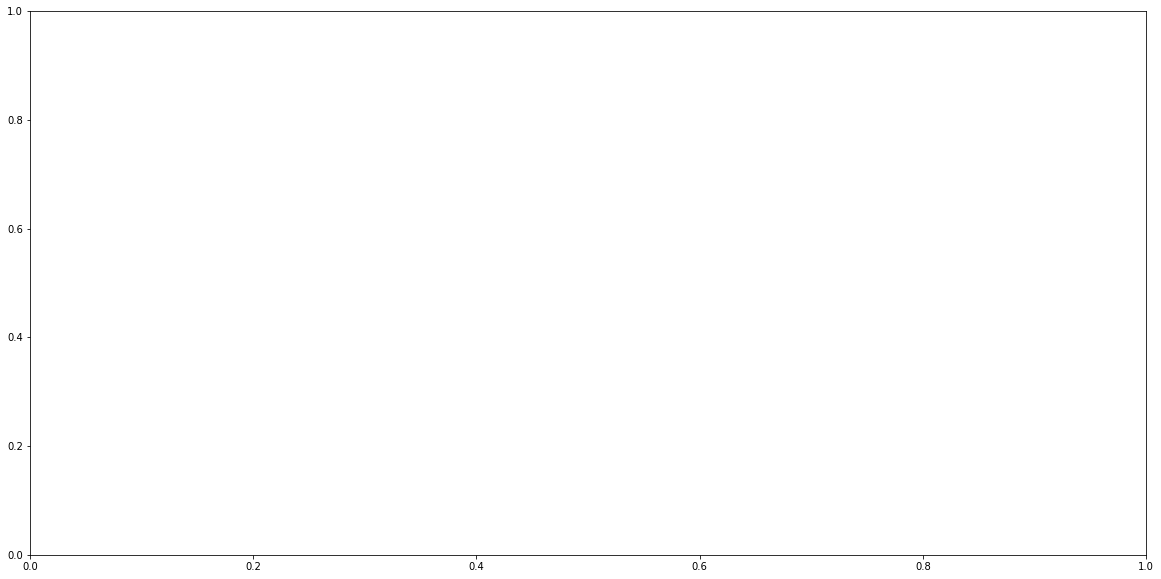

In [11]:
with open("DDQN3_3.pkl", "wb") as f: 
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open("results/replay_memory_size_effect.pkl", "rb") as f: 
    data = pickle.load(f)
    
data

In [ ]:
-(3 > 2) * 2
